# Fraud Detection Using Anomaly Detection

This project explores the use of anomaly detection techniques to identify potentially fraudulent transactions in tabular data.

Fraud detection is a challenging real-world problem due to:
- Class imbalance
- Evolving fraud patterns
- Limited labeled data

In this notebook, I evaluate multiple anomaly detection approaches and compare their strengths, limitations, and suitability for real-world deployment.

## Project Overview

**Objective:**  
Detect anomalous (potentially fraudulent) observations using unsupervised and semi-supervised methods.

**Approach:**  
I compare three families of anomaly detection techniques:
1. Statistical methods (Z-score)
2. Clustering-based methods
3. Autoencoder-based reconstruction models

**Key Questions:**
- Which methods are most sensitive to rare anomalies?
- How do model assumptions affect results?
- What are the trade-offs between interpretability and performance?


## Dataset Description

The dataset contains transaction-level data from an e-commerce platform.  
Each row represents a **single product purchase** made by a client at a specific date and time.

The goal of this project is to identify **fraudulent transactions**, where fraud is indicated by a binary target variable.  
The dataset includes **temporal, transactional, customer, and payment-related features**, making it suitable for anomaly detection and fraud analysis.

---

## Feature Description

| Column name | Description |
|------------|-------------|
| `transaction_id` | Unique identifier for each transaction |
| `date_heure` | Date and time at which the transaction was completed |
| `client_id` | Unique identifier of the client who performed the transaction |
| `produit_id` | Unique identifier of the product purchased |
| `categorie` | Product category |
| `quantité` | Quantity of the product purchased in the transaction |
| `prix_unitaire` | Unit price of the product |
| `moyen_paiement` | Payment method used for the transaction (e.g., card, transfer, etc.) |
| `ville` | City from which the transaction was made |
| `âge_client` | Age of the client |
| `ancienneté_compte_jours` | Number of days since the client account was created |
| `montant_total` | Total transaction amount (`quantité × prix_unitaire`) |
| `fraude` | Binary label indicating whether the transaction is fraudulent (1 = fraud, 0 = legitimate) |

---

## Notes

Fraudulent transactions are relatively rare compared to legitimate ones, resulting in a **highly imbalanced dataset**.  
This motivates the use of **anomaly detection techniques**, which are well suited for identifying unusual patterns when labeled fraud data is limited.

## 1. Exploratory Data Analysis

### Install and Import Modules

In [3]:
'''
%pip install -U "matplotlib>=3.9"
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install seaborn
!pip install matplotlib
!pip install tensorflow
'''

'\n%pip install -U "matplotlib>=3.9"\n!pip install pandas\n!pip install numpy\n!pip install scikit-learn\n!pip install seaborn\n!pip install matplotlib\n!pip install tensorflow\n'

In [4]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import math
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import precision_recall_curve, f1_score, confusion_matrix, classification_report, pairwise_distances
from scipy import stats
from scipy.spatial.distance import mahalanobis, cdist
from sklearn.covariance import MinCovDet
from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

In [5]:
# Ensure reproduceability of results
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [6]:
ROOT = ""
df = pd.read_csv(ROOT+'DATA/transactions_ecommerce.csv')

In [7]:
df.head()

,transaction_id,date_heure,client_id,produit_id,catégorie,quantité,prix_unitaire,moyen_paiement,ville,âge_client,ancienneté_compte_jours,fraude,montant_total
0,10000,2023-06-08 12:00:00,C1028,P267,Décoration,1,197.21,PayPal,Toulouse,57,144,0,197.21
1,10001,2023-05-29 19:00:00,C1906,P178,Art de la table,5,41.54,Virement,Bordeaux,69,750,0,207.70
2,10002,2023-05-08 13:00:00,C1032,P253,Art de la table,4,31.74,Carte,Paris,20,784,0,126.96
3,10003,2023-06-08 18:00:00,C1645,P415,Décoration,2,11.65,Carte,Paris,29,632,0,23.30
4,10004,2023-05-19 15:00:00,C1878,P056,Décoration,3,39.56,PayPal,Bordeaux,56,340,0,118.68


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   transaction_id           1050 non-null   int64  
 1   date_heure               1050 non-null   object 
 2   client_id                1050 non-null   object 
 3   produit_id               1050 non-null   object 
 4   catégorie                1050 non-null   object 
 5   quantité                 1050 non-null   int64  
 6   prix_unitaire            1050 non-null   float64
 7   moyen_paiement           1050 non-null   object 
 8   ville                    1050 non-null   object 
 9   âge_client               1050 non-null   int64  
 10  ancienneté_compte_jours  1050 non-null   int64  
 11  fraude                   1050 non-null   int64  
 12  montant_total            1050 non-null   float64
dtypes: float64(2), int64(5), object(6)
memory usage: 106.8+ KB


- There are 6 numerical columns (excluding the target) and 6 categorical columns
- There are no missing data in the columns

### Visualizing the target distribution

In [9]:
fraud_counts = df['fraude'].value_counts().sort_index()
labels = {
    0: "Fraude(0) - Non",
    1: "Fraude(1) - Oui"
}


# Affficher le nombere et le pourcentage d'anomalies
anomalies = df[df['fraude'] == 1]
print(f"Le nombre d'anomalies: {len(anomalies)}")
print(f"Le pourcentage d'anomalies: {len(df[df['fraude'] == 1]) * 100/len(df)}")

# Affichage d'un pie chart
fig = px.pie(names=[labels[i] for i in fraud_counts.index], values=fraud_counts.values, title='La répartition des classes de la variable fraude', color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_traces(labels=["Fraude(0) - Non", "Fraude(1) - Oui"], selector=dict(type='pie'))

fig.update_traces(
    textinfo="percent",
    texttemplate="%{percent:.4%}",  
    textposition="inside",
    hovertemplate="%{label}<br>%{value} (%{percent:.4%})<extra></extra>"
)
fig.show()


Le nombre d'anomalies: 50
Le pourcentage d'anomalies: 4.761904761904762


In [10]:
df.drop(columns=['fraude']).describe()

,transaction_id,quantité,prix_unitaire,âge_client,ancienneté_compte_jours,montant_total
count,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000
mean,10953.071429,3.718095,135.683495,43.889524,491.700000,428.652848
std,2048.881096,6.671836,343.409818,14.591455,286.729619,904.875595
min,10000.000000,1.000000,10.040000,18.000000,1.000000,10.960000
25%,10262.250000,2.000000,55.480000,31.000000,253.000000,127.025000
50%,10524.500000,3.000000,103.130000,44.000000,495.000000,256.630000
75%,10786.750000,4.000000,152.007500,56.000000,730.750000,463.777500
max,20049.000000,95.000000,4995.620000,69.000000,999.000000,12517.050000


In [11]:
variables_num = df.select_dtypes(include=['int64', 'float64']).drop(columns=['fraude'])
for col in variables_num:
    fig = px.box(df, x=col, points="outliers", title=f"Boxplot de {col}", color_discrete_sequence=px.colors.sequential.RdBu)
    fig.show()

In [12]:
variables_cat = df.select_dtypes(include='object').drop(columns=['date_heure', 'client_id', 'produit_id'])

# Affichage des valeurs uniques et visualisation de la répartition en pourcentage
for col in variables_cat:
    valeur_uniques = df[col].value_counts()
    print(f"Les valeurs uniques de pour {valeur_uniques.index.to_list()}.")
    print("====================================================================================")
    fig = px.pie(values=valeur_uniques.values, names=valeur_uniques.index, title=f"La répartition de {col}", color_discrete_sequence=px.colors.sequential.RdBu)
    fig.show()

Les valeurs uniques de pour ['Art de la table', 'Textile', 'Cuisine', 'Décoration'].


Les valeurs uniques de pour ['PayPal', 'Carte', 'Virement'].


Les valeurs uniques de pour ['Lyon', 'Bordeaux', 'Paris', 'Marseille', 'Toulouse'].


## Baseline Approach: Statistical Anomaly Detection (Z-score)

As a baseline, I apply Z-score–based anomaly detection, which flags observations that deviate significantly from the mean under the assumption of approximately normal feature distributions.

### Strengths and Limitations

- ✔ Simple and interpretable
- ✔ Fast to compute
- ✖ Sensitive to non-Gaussian distributions
- ✖ Ignores feature interactions


In [13]:
def detect_anomalies_zscore(data, column, threshold=3):
    """
    Détecte les anomalies avec la méthode du Z-Score.

    Paramètres
    ----------
    data : DataFrame
        Données d’entrée.
    column : str
        Colonne cible.
    threshold : float
        Seuil Z-Score.

    Retourne
    --------
    DataFrame
        Lignes anormales.
    """

    z_scores = stats.zscore(data[column]).abs()
    anomalies_idx = z_scores[z_scores > threshold].index
    return df.loc[anomalies_idx]

**Applying the function on `montant_total` and `quantité`**.

In [14]:
anomalies_par_montant = detect_anomalies_zscore(df, 'montant_total')
anomalies_par_montant

,transaction_id,date_heure,client_id,produit_id,catégorie,quantité,prix_unitaire,moyen_paiement,ville,âge_client,ancienneté_compte_jours,fraude,montant_total
1000,20000,2023-05-24 00:00:00,C3010,P558,Décoration,1,4978.38,Virement,Lyon,69,585,1,4978.38
1001,20001,2023-05-01 00:00:00,C3016,P594,Textile,27,213.56,PayPal,Bordeaux,66,1,1,5766.12
1004,20004,2023-06-25 00:00:00,C3331,P567,Cuisine,1,3287.59,Carte,Lyon,62,447,1,3287.59
1005,20005,2023-06-09 00:00:00,C3811,P585,Textile,2,2927.98,Virement,Lyon,39,528,1,5855.96
1006,20006,2023-06-26 00:00:00,C3573,P581,Cuisine,91,137.55,PayPal,Lyon,40,359,1,12517.05
1010,20010,2023-06-06 00:00:00,C3467,P597,Décoration,70,145.11,PayPal,Lyon,23,635,1,10157.70
1015,20015,2023-06-10 00:00:00,C3338,P529,Art de la table,50,89.86,Virement,Marseille,41,743,1,4493.00
1017,20017,2023-05-07 00:00:00,C3986,P546,Art de la table,20,185.19,Virement,Bordeaux,39,2,1,3703.80
1019,20019,2023-05-10 00:00:00,C3328,P558,Cuisine,23,215.48,Carte,Marseille,19,1,1,4956.04
1020,20020,2023-06-19 00:00:00,C3791,P526,Art de la table,16,265.69,PayPal,Marseille,18,2,1,4251.04


In [15]:
anomalies_par_quantité = detect_anomalies_zscore(df, 'quantité')
anomalies_par_quantité

,transaction_id,date_heure,client_id,produit_id,catégorie,quantité,prix_unitaire,moyen_paiement,ville,âge_client,ancienneté_compte_jours,fraude,montant_total
1001,20001,2023-05-01 00:00:00,C3016,P594,Textile,27,213.56,PayPal,Bordeaux,66,1,1,5766.12
1002,20002,2023-06-22 00:00:00,C3973,P543,Cuisine,24,66.75,PayPal,Toulouse,58,2,1,1602.00
1006,20006,2023-06-26 00:00:00,C3573,P581,Cuisine,91,137.55,PayPal,Lyon,40,359,1,12517.05
1010,20010,2023-06-06 00:00:00,C3467,P597,Décoration,70,145.11,PayPal,Lyon,23,635,1,10157.70
1011,20011,2023-06-27 00:00:00,C3855,P512,Cuisine,28,75.24,Virement,Marseille,45,1,1,2106.72
1015,20015,2023-06-10 00:00:00,C3338,P529,Art de la table,50,89.86,Virement,Marseille,41,743,1,4493.00
1025,20025,2023-05-26 00:00:00,C3460,P558,Textile,60,105.77,Carte,Bordeaux,65,433,1,6346.20
1026,20026,2023-06-16 00:00:00,C3055,P564,Textile,84,103.63,Carte,Paris,59,672,1,8704.92
1036,20036,2023-06-13 00:00:00,C3867,P542,Art de la table,59,80.91,PayPal,Paris,26,957,1,4773.69
1042,20042,2023-05-17 00:00:00,C3934,P589,Textile,95,108.07,Virement,Bordeaux,38,979,1,10266.65


### 2.1: Evaluate Performance

In [16]:
def evaluate_performance(anomalies_detectees, vraies_anomalies):
    """
    Évalue la performance de détection.

    Paramètres
    ----------
    anomalies_detectees : DataFrame
        Anomalies prédites.
    vraies_anomalies : DataFrame
        Anomalies réelles.

    Retourne
    --------
    dict
        Métriques d’évaluation.
    """

    # On suppose que l'identifiant unique est l'index du DataFrame pour la calcule des vrais positifs et faux positifs
    vrais_positifs = len(set(anomalies_detectees.index).intersection(set(vraies_anomalies.index)))
    faux_positifs = len(set(anomalies_detectees.index).difference(set(vraies_anomalies.index)))
    
    # Précision : proportion de détections correctes parmi les anomalies détectées
    precision = vrais_positifs / (vrais_positifs + faux_positifs) if (vrais_positifs + faux_positifs) > 0 else 0.0

    # Rappel : proportion de vraies anomalies détectées
    rappel = vrais_positifs / len(vraies_anomalies) if len(set(vraies_anomalies.index)) > 0 else 0.0
   
    return {
        "vrais_positifs": vrais_positifs, 
        "faux_positifs": faux_positifs, 
        "precision": precision, 
        "rappel": rappel}

**Evaluating the performance on the `montant_total` et `quantité` columns**

In [17]:
# Evaluation de z_score par montant_total
print("La performance de la detection d'anomalies par Zscore d'attribute montant_total")
print("=" * 80)
perf_zcore_montant = evaluate_performance(anomalies_par_montant, anomalies)
for k,v in perf_zcore_montant.items():
    print(k, v)

La performance de la detection d'anomalies par Zscore d'attribute montant_total
vrais_positifs 19
faux_positifs 0
precision 1.0
rappel 0.38


### Comment
- A perfect precision (1.0) = all anomaly predicted are real fraudulent transactions.
- However, a weak recall (0.38) = this approach only detects a small fraction of real fraudulent transactions.  
- In conclusion, this approach is conservative = Reliable when an alert is raised, but insufficient for exhaustive fraud detection.

In [18]:
# Evaluation de z_score par quantité
print("La performance de la detection d'anomalies par Zscore d'attribute quantité")
print("=" * 75)
perf_zscore_quantite = evaluate_performance(anomalies_par_quantité, anomalies)
for k,v in perf_zscore_quantite.items():
    print(k, v)

La performance de la detection d'anomalies par Zscore d'attribute quantité
vrais_positifs 11
faux_positifs 0
precision 1.0
rappel 0.22


- **Perfect precision (1.0):** All detected anomalies correspond to actual fraudulent transactions.
- **Low recall (0.22):** This approach identifies only a small fraction of the true fraud cases.
- **Highly conservative behavior:** The method detects only the most extreme quantity anomalies and fails to capture the majority of fraudulent transactions.

## 3. Clustering-Based Anomaly Detection

Clustering methods assume that normal observations form dense groups, while anomalies appear as isolated points or small clusters.

### 3.1. Data Preprocessing

Before applying anomaly detection models, the data is preprocessed to ensure that features are suitable for machine learning algorithms.

Categorical variables are encoded using **One-Hot Encoding**, while numerical variables are **standardized** to ensure comparable feature scales.

The following variables are excluded from the preprocessing step, as they represent identifiers, timestamps, or the target label rather than informative features:

- `date_heure`
- `client_id`
- `produit_id`
- `transaction_id`
- `fraude`

To avoid multicollinearity, the column corresponding to the **first category of each categorical variable** is removed after encoding.

Finally, the number of features and the data type of each column are displayed **before and after preprocessing** in order to verify the transformation pipeline.

In [19]:
def preprocess_data(df):
    """
    Prépare les données pour l’analyse.

    Paramètres
    ----------
    df : DataFrame
        Données brutes.

    Retourne
    --------
    DataFrame
        Données prétraitées.
    """
    # Variables à exclure
    excluded_vars = ['date_heure', 'client_id', 'produit_id', 'transaction_id', 'fraude']

    # Affichage avant prétraitement
    print("Avant prétraitement :")
    print("Nombre de colonnes :", df.shape[1])
    print(df.dtypes)

    # Séparer variables numériques et catégorielles
    num_vars = df.select_dtypes(include=['int64','float64']).columns.difference(excluded_vars)
    cat_vars = df.select_dtypes(include=['object']).columns.difference(excluded_vars)

    # Standardisation des variables numériques
    scaler = StandardScaler()
    df_num = pd.DataFrame(scaler.fit_transform(df[num_vars]), columns=num_vars, index=df.index)

    # Encodage One-Hot des variables catégorielles (drop_first pour éviter multicolinéarité)
    df_cat = pd.get_dummies(df[cat_vars], drop_first=True).astype(int)
    # Concaténer les données prétraitées avec les colonnes exclues 
    df_preprocessed = pd.concat([df_num, df_cat], axis=1)

    # Affichage après prétraitement
    print("\nAprès prétraitement :")
    print("Nombre de colonnes :", df_preprocessed.shape[1])
    print(df_preprocessed.dtypes)

    return df_preprocessed

In [20]:
preprocessed_df = preprocess_data(df)

Avant prétraitement :
Nombre de colonnes : 13
transaction_id               int64
date_heure                  object
client_id                   object
produit_id                  object
catégorie                   object
quantité                     int64
prix_unitaire              float64
moyen_paiement              object
ville                       object
âge_client                   int64
ancienneté_compte_jours      int64
fraude                       int64
montant_total              float64
dtype: object

Après prétraitement :
Nombre de colonnes : 14
ancienneté_compte_jours    float64
montant_total              float64
prix_unitaire              float64
quantité                   float64
âge_client                 float64
catégorie_Cuisine            int64
catégorie_Décoration         int64
catégorie_Textile            int64
moyen_paiement_PayPal        int64
moyen_paiement_Virement      int64
ville_Lyon                   int64
ville_Marseille              int64
ville_Paris       

### 3.2: Cluster Selection Using the Silhouette Score

To identify an appropriate number of clusters for the preprocessed dataset (`preprocessed_df`), the **silhouette score** is used as a model selection criterion in combination with **K-Means clustering**.

The number of clusters \( k \) is evaluated over a range from **2 to 10**, and the corresponding silhouette scores are computed and visualized.  
The optimal value of \( k \) is selected as the one that **maximizes the silhouette score**, indicating well-separated and cohesive clusters.

For reproducibility and stability of the results, the K-Means algorithm is initialized with `random_state=42` and executed with `n_init=10`, ensuring that the best clustering solution is retained across multiple initializations.


In [21]:
# Plage de valeurs de k
range_n_clusters = range(2, 11)
silhouette_scores = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(preprocessed_df)
    score = silhouette_score(preprocessed_df, cluster_labels)
    silhouette_scores.append(score)

In [22]:
fig = px.line(
    x = range_n_clusters, 
    y = silhouette_scores, 
    markers=True,
    title= "Score de silhouette en fonction du nombre de clusters", 
    labels={"x": "Nombre de clusters (k)", "y": "Score de silhouette"}, 
    color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_traces(marker_size=20)
fig.update_layout()
fig.show()

#### Comment
- Based on the silhouette analysis, k = 2 is selected as the optimal number of clusters, as it provides the highest silhouette score among the tested values.


### 3.3. Outlier Detection Using Cluster-Based Mahalanobis Distance

After selecting the optimal number of clusters, **K-Means clustering** is applied to the preprocessed data.

For each data point, an **outlier score** is computed using the **Mahalanobis distance** relative to the centroid of its assigned cluster. This distance measures how far a point deviates from the multivariate distribution of its cluster, taking feature correlations into account.

The Mahalanobis distance for a point \( X_i \) with respect to cluster \( r \) is defined as:

\[
\text{Maha}(X_i, \mu_r, \Sigma_r) = \sqrt{(X_i - \mu_r) \, \Sigma_r^{-1} \, (X_i - \mu_r)^T}
\]

where:
- \( X_i \) is the observation being evaluated  
- \( \mu_r \) is the centroid of cluster \( r \)  
- \( \Sigma_r \) is the covariance matrix of cluster \( r \)

If the covariance matrix is not invertible, its **pseudo-inverse** is used to ensure numerical stability.


In [23]:
def compute_outlier_scores_k2(data):
    """
    Applique KMeans avec k=2 et calcule le score d'outlier
    de chaque point via la distance de Mahalanobis.
    
    Paramètres
    ----------
    data : DataFrame ou ndarray
        Données prétraitées.
    
    Retourne
    --------
    DataFrame
        Données avec colonnes 'cluster' et 'mahalanobis_score'.
    """
    # Appliquer KMeans avec k=2
    X = data.to_numpy(dtype=np.float64)
    
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    labels = kmeans.fit_predict(data)

    # Construire un DataFrame avec les données + labels
    data_with_scores = pd.DataFrame(data, index=data.index)
    data_with_scores['cluster'] = labels

    # Tableau pour stocker les scores de Mahalanobis
    mahalanobis_scores = np.empty(X.shape[0], dtype=np.float64)

    # Étape 2 : Calcul des distances de Mahalanobis par cluster
    for cluster_id in (0, 1):

        # Sélection des points appartenant au cluster courant
        mask = labels == cluster_id
        X_cluster = X[mask]

        # Calcul de la moyenne du cluster
        moyenne = X_cluster.mean(axis=0)

        # Calcul de la matrice de covariance
        if X_cluster.shape[0] < 2:
            # Cas dégénéré : trop peu de points
            covariance = np.eye(X.shape[1], dtype=np.float64)
        else:
            covariance = np.cov(X_cluster, rowvar=False)
            covariance = np.atleast_2d(covariance).astype(np.float64)

        # Régularisation pour éviter les matrices singulières
        covariance += np.eye(covariance.shape[0]) * 1e-6

        # Inverse (ou pseudo-inverse) de la covariance
        covariance_inv = np.linalg.pinv(covariance)

        # Calcul vectorisé des distances de Mahalanobis (SciPy)
        mahalanobis_scores[mask] = cdist(
            X_cluster,
            moyenne.reshape(1, -1),
            metric="mahalanobis",
            VI=covariance_inv
        ).ravel()

    # Ajout des scores au DataFrame
    data_with_scores["mahalanobis_score"] = mahalanobis_scores

    return data_with_scores


**Display the distribution of the Mahalanobis distances.**

In [24]:
scores_df = compute_outlier_scores_k2(preprocessed_df)

fig = px.histogram(
    scores_df, 
    x= "mahalanobis_score", 
    labels="Mahalanobis scores", 
    title="Distribution des distances de Mahalanobis",
    color_discrete_sequence=px.colors.sequential.RdBu, 
    nbins=30)
fig.update_layout(xaxis_title="Distance de Mahalanobis", yaxis_title="Fréquence")

### Anomaly Thresholding and Performance Evaluation

Using the Mahalanobis distance scores computed for each observation, an anomaly detection threshold is defined based on the **95th percentile** of the distance distribution.

Observations with a Mahalanobis distance **strictly greater than this threshold** are flagged as anomalous.

The detection results are then evaluated by comparing the identified anomalies against the ground-truth fraud labels (`fraude`). Performance is assessed using standard classification metrics, including:
- True positives and false positives
- Precision, recall, and F1-score

The results are analyzed to highlight the strengths and limitations of this approach in identifying fraudulent transactions.

In [25]:
#1: #  Déterminer le seuil d’anomalie (95e percentile)
seuil_anomalie = scores_df["mahalanobis_score"].quantile(0.95)

#2: Détecter les anomalies
detected_idx = scores_df.index[scores_df["mahalanobis_score"] > seuil_anomalie]
kmeans_anomalies = scores_df.loc[detected_idx]

# 3a: Calulate the number of VP, FP, Precision, Rappel and F1_score
kmeans_performance = evaluate_performance(kmeans_anomalies, anomalies)

vp_kmeans = kmeans_performance['vrais_positifs']
fp_Kmeans = kmeans_performance['faux_positifs']
precision_kmeans = kmeans_performance['precision']
rappel_kmeans = kmeans_performance['rappel']

denom = precision_kmeans + rappel_kmeans
f1score_kmeans = 2 * (precision_kmeans * rappel_kmeans)/ denom if denom > 0 else 0

# Affichage de résultats
print("La performance de la detection d'anomalies par kmeans")
print("=" * 53)
print("Seuil d’anomalie (95e percentile) :", seuil_anomalie)
print("Vrai Positifs: ", vp_kmeans)
print("Faux Positifs: ", fp_Kmeans)
print("Precision: ", precision_kmeans)
print("Rappel: ", rappel_kmeans)
print("F1 Score: ", f1score_kmeans)


La performance de la detection d'anomalies par kmeans
Seuil d’anomalie (95e percentile) : 3.9843267642737805
Vrai Positifs:  17
Faux Positifs:  36
Precision:  0.32075471698113206
Rappel:  0.34
F1 Score:  0.3300970873786408


## **Results Commentary**

### **Overall Performance: Poor**

The obtained metrics indicate **weak overall performance** of the model:

- **Precision = 32.1%:** Only 1 out of 3 transactions flagged as fraudulent is actually fraud. The remaining cases are false alarms.

- **Recall = 34%:** The model detects only one-third of the actual fraud cases. **66% of fraudulent transactions go undetected**, which is highly concerning.

- **F1-Score = 33%:** This score reflects a poor balance between precision and recall, confirming the unsatisfactory overall performance.

### **Confusion Matrix Analysis**

- \( TP = 17 \): Very few fraudulent transactions are correctly identified  
- \( FN = 33 \): The number of missed fraud cases is **twice as high** as the number of detected ones  
- \( FP = 36 \): A significant number of false alerts, which could negatively impact legitimate customers  
- \( TN = 964 \): The model performs well in identifying normal transactions  

### **Verdict**

The current model is **insufficient** for practical fraud detection, as it fails to detect the majority of fraudulent cases while generating a substantial number of false alerts. The selected threshold (95th percentile) appears too strict, capturing only extreme anomalies and failing to identify more subtle fraudulent patterns in the data.


## 4. Deep Learning Approach: Autoencoder-Based Anomaly Detection

Autoencoders learn a compressed representation of normal data.  
Anomalies are detected based on high reconstruction error.

### 4.1 Data preparation (Train and Test data)

In [26]:
# Séparer les données frauduleuses et non frauduleuses
mask_fraude = df['fraude'] == 1
mask_normal = df['fraude'] == 0

# Données non frauduleuses
X_normal = preprocessed_df[mask_normal]
y_normal = df.loc[mask_normal, 'fraude']

# Données frauduleuses
X_fraude = preprocessed_df[mask_fraude]
y_fraude = df.loc[mask_fraude, 'fraude']

# Diviser les données non frauduleuses en train (80%) et test (20%)
X_train, X_test_normal, y_train, y_test_normal = train_test_split(
    X_normal, 
    y_normal, 
    test_size=0.2, 
    random_state=42,
    shuffle=True
)

# Ajouter toutes les données frauduleuses à l'ensemble de test
X_test = pd.concat([X_test_normal, X_fraude], axis=0)
y_test = pd.concat([y_test_normal, y_fraude], axis=0)


### 4.2 Model Building

The model architecture follows a symmetric **encoder–decoder** structure:

#### Input Layer
- Input dimension equal to the number of features in the dataset (`input_dim`).

#### Encoder
- Dense layer with `hidden_dim1` units and ReLU activation  
- Batch normalization to stabilize training  
- Dropout with rate `dropout_rate` to reduce overfitting  
- Dense layer with `hidden_dim2` units and ReLU activation  
- Dense latent representation layer with `encoding_dim` units and ReLU activation  

#### Decoder
The decoder mirrors the encoder architecture **without batch normalization or dropout**:
- Dense layer with `hidden_dim2` units and ReLU activation  
- Dense layer with `hidden_dim1` units and ReLU activation  
- Output layer with `input_dim` units and linear activation  

#### Model Compilation
The autoencoder is compiled using:
- **Optimizer:** Adam  
- **Learning rate:** value specified by `learning_rate`  
- **Loss function:** Mean Squared Error (MSE)  
- **Evaluation metric:** Mean Absolute Error (MAE)

In [27]:
class Autoencoder:

    def __init__(self, input_dim, encoding_dim=7, hidden_dim1=32, hidden_dim2=16, learning_rate=0.001, dropout_rate=0.1):
        """
        Initialisation de l'autoencodeur.

        Paramètres
        ----------
        input_dim : int
            Dimension des données d'entrée.
        encoding_dim : int
            Dimension de l'espace latent (bottleneck).
        hidden_dim1 : int
            Taille de la première couche cachée.
        hidden_dim2 : int
            Taille de la deuxième couche cachée.
        learning_rate : float
            Taux d'apprentissage.
        dropout_rate : float
            Taux de dropout pour la régularisation.
        """
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.learning_rate = learning_rate
        self.dropout_rate = dropout_rate

        self.model = None

        self._build_autoencoder()

    def _build_autoencoder(self):
        """Construction de l'architecture de l'autoencodeur."""
        # Couche d'entrée
        couche_entrée = Input(shape=(self.input_dim,))

        # Encodeur
        enc_layer_1 = Dense(self.hidden_dim1, activation='relu')(couche_entrée)
        batch_norm = BatchNormalization()(enc_layer_1)
        drop_out = Dropout(rate=self.dropout_rate)(batch_norm)
        enc_layer_2 = Dense(self.hidden_dim2, activation='relu')(drop_out)
        enc_layer_3 = Dense(self.encoding_dim, activation='relu')(enc_layer_2)

        # Décodeur
        dec_layer_1 = Dense(self.hidden_dim2, activation='relu')(enc_layer_3)
        dec_layer_2 = Dense(self.hidden_dim1, activation='relu')(dec_layer_1)
        dec_layer_3 = Dense(self.input_dim)(dec_layer_2)

        # Modèle complet
        self.model = Model(inputs=couche_entrée, outputs=dec_layer_3)

        # Compilation
        self.model.compile(
            optimizer=Adam(learning_rate=self.learning_rate), 
            loss=MeanSquaredError(),
            metrics=[MeanAbsoluteError()],
        )

    def summary(self):
        """Affiche le résumé du modèle complet."""
        if self.model is not None:
            self.model.summary()
        else:
            print("Le modèle n'a pas encore été construit.")

**Initialize the autoencoder and inspect its architecture using the model summary.**

In [28]:
# Initialiser l'autoencodeur
input_dim = X_train.shape[1]  # Nombre de features

autoencoder = Autoencoder(input_dim)

# Afficher le résumé du modèle
summary = autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           119 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 14)             │           462 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,389 (9.33 KB)

 Trainable params: 2,325 (9.08 KB)

 Non-trainable params: 64 (256.00 B)

### 4.3 Model Training

The autoencoder is trained for 50 epochs with a batch size of 32, using a 10% validation split and shuffling the samples at each epoch.

In [29]:
# Entraîner l'autoencodeur
history = autoencoder.model.fit(
    X_train, 
    X_train,  # L'autoencodeur apprend à reconstruire ses entrées
    epochs=50,
    batch_size=32,
    validation_split=0.1,  # 10% des données pour la validation
    shuffle=True,  # Mélange aléatoire à chaque époque
    verbose=1
)

Epoch 1/50


2026-01-20 12:39:58.928422: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3304 - mean_absolute_error: 0.3748 - val_loss: 0.2862 - val_mean_absolute_error: 0.3309
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2740 - mean_absolute_error: 0.3545 - val_loss: 0.2644 - val_mean_absolute_error: 0.3438
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2406 - mean_absolute_error: 0.3600 - val_loss: 0.2433 - val_mean_absolute_error: 0.3456
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2156 - mean_absolute_error: 0.3488 - val_loss: 0.2227 - val_mean_absolute_error: 0.3395
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1959 - mean_absolute_error: 0.3380 - val_loss: 0.2035 - val_mean_absolute_error: 0.3346
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1774 - mean_absolute_error: 0.3277 - val_loss: 0.1832 - val_mean_absolute_error: 0.3218
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1646 - mean_absolute_error: 0.3177 - val_loss: 0.1671 - val_me

In [30]:
fit_data = history.history

Visualizing the training abd validation loss curves of the autoencoder

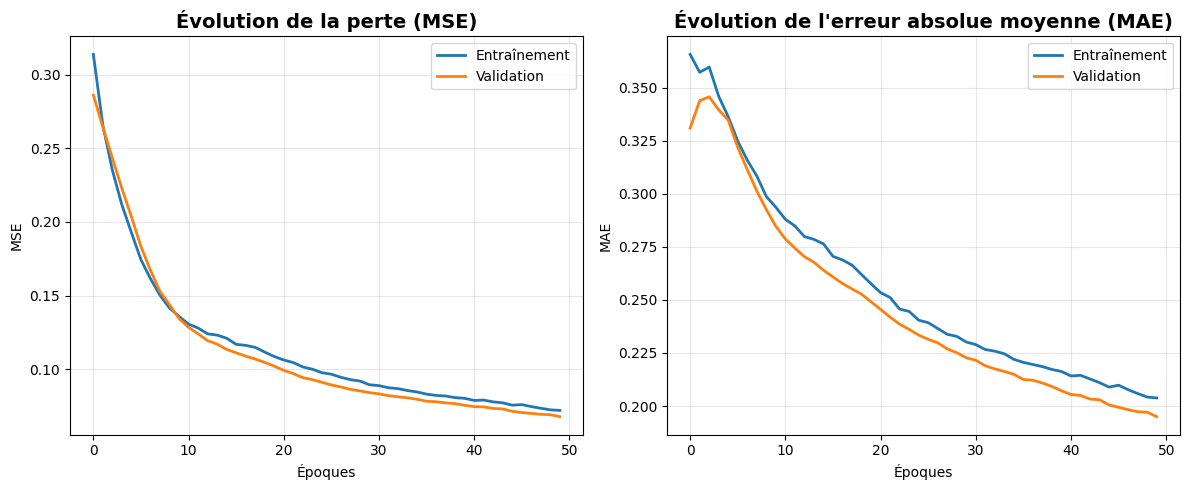

In [31]:
# Tracer les courbes de perte
plt.figure(figsize=(12, 5))

# Graphique 1: Loss (MSE)
plt.subplot(1, 2, 1)
plt.plot(fit_data['loss'], label='Entraînement', linewidth=2)
plt.plot(fit_data['val_loss'], label='Validation', linewidth=2)
plt.title('Évolution de la perte (MSE)', fontsize=14, fontweight='bold')
plt.xlabel('Époques')
plt.ylabel('MSE')
plt.legend()
plt.grid(True, alpha=0.3)

# Graphique 2: MAE
plt.subplot(1, 2, 2)
plt.plot(fit_data['mean_absolute_error'], label='Entraînement', linewidth=2)
plt.plot(fit_data['val_mean_absolute_error'], label='Validation', linewidth=2)
plt.title('Évolution de l\'erreur absolue moyenne (MAE)', fontsize=14, fontweight='bold')
plt.xlabel('Époques')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### **Commentary**

#### **Key Observations**

**1. Fast and effective convergence**
- Both metrics (MSE and MAE) decrease **rapidly** during the first 20 epochs  
- The MSE drops from ~0.31 to ~0.08 (≈74% reduction)  
- The MAE decreases from ~0.36 to ~0.20 (≈44% reduction)  

**2. Absence of overfitting**
- The **training** and **validation** curves remain **very close** throughout the training process  
- The validation curve **never diverges** from the training curve  
- This indicates that the model **generalizes well** and does not memorize the training data  

**3. Progressive stabilization**
- After epoch 30, the curves stabilize and converge toward:
  - Final MSE: ≈0.07 (training) and ≈0.068 (validation)  
  - Final MAE: ≈0.20 (training) and ≈0.195 (validation)  
- The gap between training and validation remains **minimal** (< 0.01)  

**4. Effectiveness of regularization**
- **Dropout (10%)** and **Batch Normalization** helped prevent overfitting  
- The model learned **robust representations** of normal transaction behavior  


### 4.4 Autoencoder Reconstruction Error Computation

The reconstruction error produced by the autoencoder is computed for each observation as the **Euclidean distance** between the original input vector and its reconstructed output:

$$
\text{Error}_i = \sqrt{\sum_{k=1}^{d} (x_{ik} - \hat{x}_{ik})^2}
= \lVert X_i - \hat{X}_i \rVert_2
$$

where:
- **i** denotes the observation index  
- **d** is the number of input features  
- **xᵢₖ** represents the original value of feature *k*  
- **x̂ᵢₖ** is the reconstructed value produced by the autoencoder  

Reconstruction errors are computed and analyzed on the **test dataset** to identify observations that deviate significantly from normal transaction patterns.


In [32]:
# Calculer les reconstructions de l'autoencodeur sur les données de test
X_test_reconstructed = autoencoder.model.predict(X_test)

# S'assurer que tout est en numpy array de type float
X_test_array = np.array(X_test, dtype=np.float64)
X_test_reconstructed = np.array(X_test_reconstructed, dtype=np.float64)

# Calculer l'erreur de reconstruction pour chaque point (norme L2)
differences = X_test_array - X_test_reconstructed
squared_differences = differences ** 2
sum_squared = np.sum(squared_differences, axis=1)
reconstruction_errors = np.sqrt(sum_squared)

# Créer un DataFrame pour faciliter l'analyse
errors_df = pd.DataFrame({
    'reconstruction_error': reconstruction_errors,
    'fraude': y_test.values
})

# Affichage des statistiques
print("=" * 60)
print("ERREURS DE RECONSTRUCTION SUR L'ENSEMBLE DE TEST")
print("=" * 60)
print(f"\nNombre total de transactions : {len(reconstruction_errors)}")
print(f"Transactions normales : {(y_test == 0).sum()}")
print(f"Transactions frauduleuses : {(y_test == 1).sum()}")

print("\n" + "-" * 60)
print("STATISTIQUES GLOBALES DES ERREURS")
print("-" * 60)
print(f"Erreur minimale    : {reconstruction_errors.min():.6f}")
print(f"Erreur maximale    : {reconstruction_errors.max():.6f}")
print(f"Erreur moyenne     : {reconstruction_errors.mean():.6f}")
print(f"Erreur médiane     : {np.median(reconstruction_errors):.6f}")
print(f"Écart-type         : {reconstruction_errors.std():.6f}")

print("\n" + "-" * 60)
print("STATISTIQUES PAR CLASSE")
print("-" * 60)

# Erreurs pour les transactions normales
errors_normal = reconstruction_errors[y_test.values == 0]
print("\n Transactions NORMALES:")
print(f"   Nombre         : {len(errors_normal)}")
print(f"   Erreur moyenne : {errors_normal.mean():.6f}")
print(f"   Erreur médiane : {np.median(errors_normal):.6f}")
print(f"   Écart-type     : {errors_normal.std():.6f}")
print(f"   Min / Max      : {errors_normal.min():.6f} / {errors_normal.max():.6f}")

# Erreurs pour les transactions frauduleuses
errors_fraud = reconstruction_errors[y_test.values == 1]
print("\n  Transactions FRAUDULEUSES:")
print(f"   Nombre         : {len(errors_fraud)}")
print(f"   Erreur moyenne : {errors_fraud.mean():.6f}")
print(f"   Erreur médiane : {np.median(errors_fraud):.6f}")
print(f"   Écart-type     : {errors_fraud.std():.6f}")
print(f"   Min / Max      : {errors_fraud.min():.6f} / {errors_fraud.max():.6f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
ERREURS DE RECONSTRUCTION SUR L'ENSEMBLE DE TEST

Nombre total de transactions : 250
Transactions normales : 200
Transactions frauduleuses : 50

------------------------------------------------------------
STATISTIQUES GLOBALES DES ERREURS
------------------------------------------------------------
Erreur minimale    : 0.458860
Erreur maximale    : 18.804949
Erreur moyenne     : 1.921326
Erreur médiane     : 0.931630
Écart-type         : 3.259531

------------------------------------------------------------
STATISTIQUES PAR CLASSE
------------------------------------------------------------

 Transactions NORMALES:
   Nombre         : 200
   Erreur moyenne : 0.891273
   Erreur médiane : 0.888997
   Écart-type     : 0.210362
   Min / Max      : 0.458860 / 1.418577

  Transactions FRAUDULEUSES:
   Nombre         : 50
   Erreur moyenne : 6.041537
   Erreur médiane : 3.972255
   Écart-type     : 5.632542
   Min / Max      : 0.509233 / 18.804949


2026-01-20 12:45:51.202742: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Plotting the two histograms representing the distribution of reconstruction errors—one for normal transactions and the other for fraudulent transactions.

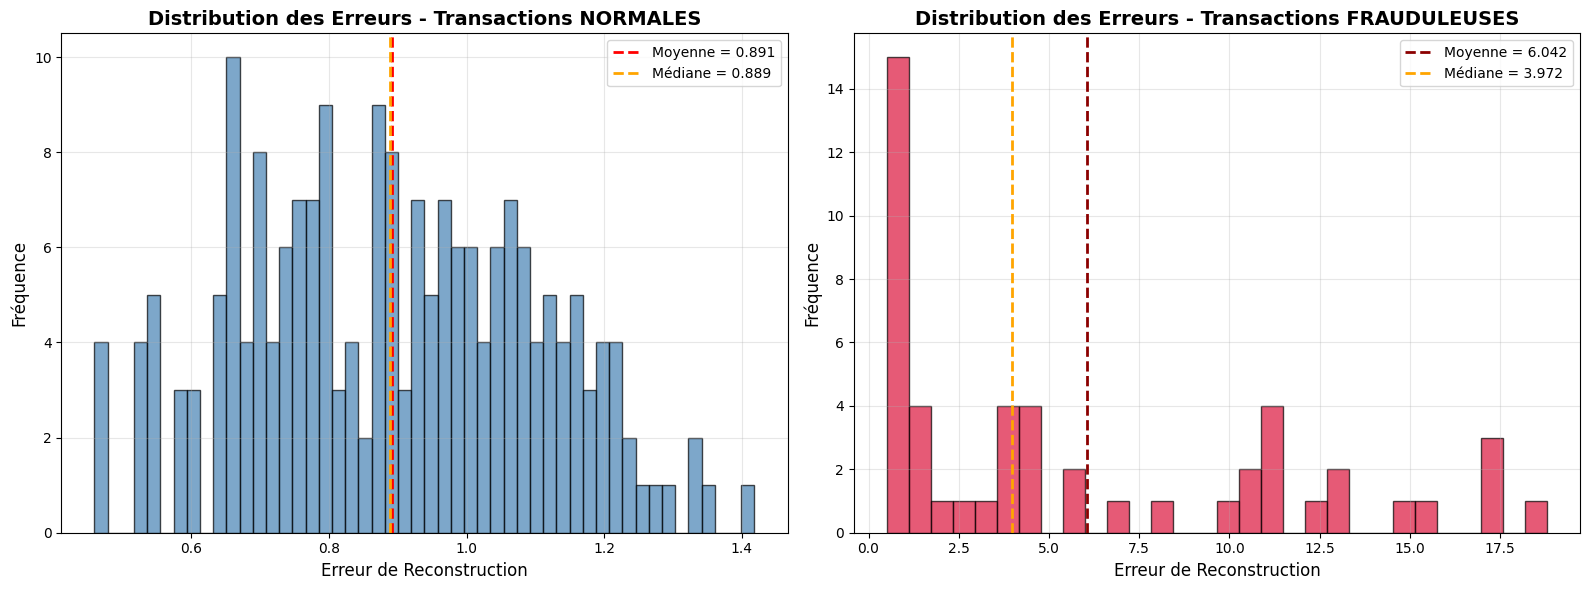

In [33]:
# Créer une figure avec deux sous-graphiques
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogramme pour les transactions NORMALES
axes[0].hist(errors_normal, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(errors_normal.mean(), color='red', linestyle='--', linewidth=2, label=f'Moyenne = {errors_normal.mean():.3f}')
axes[0].axvline(np.median(errors_normal), color='orange', linestyle='--', linewidth=2, label=f'Médiane = {np.median(errors_normal):.3f}')
axes[0].set_title('Distribution des Erreurs - Transactions NORMALES', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Erreur de Reconstruction', fontsize=12)
axes[0].set_ylabel('Fréquence', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Histogramme pour les transactions FRAUDULEUSES
axes[1].hist(errors_fraud, bins=30, color='crimson', edgecolor='black', alpha=0.7)
axes[1].axvline(errors_fraud.mean(), color='darkred', linestyle='--', linewidth=2, label=f'Moyenne = {errors_fraud.mean():.3f}')
axes[1].axvline(np.median(errors_fraud), color='orange', linestyle='--', linewidth=2, label=f'Médiane = {np.median(errors_fraud):.3f}')
axes[1].set_title('Distribution des Erreurs - Transactions FRAUDULEUSES', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Erreur de Reconstruction', fontsize=12)
axes[1].set_ylabel('Fréquence', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### **Commentary**

**NORMAL Transactions:**
- **Concentrated and nearly symmetric** distribution centered around 0.9  
- Narrow range (0.5–1.4)  
- Mean (0.891) ≈ Median (0.889) → homogeneous distribution  
- The model reconstructs normal transactions effectively  

**FRAUDULENT Transactions:**
- **Spread-out and asymmetric** distribution  
- Mean (6.042) >> Median (3.972) → long right tail  
- **14 fraudulent transactions** exhibit very low reconstruction errors (< 1), indicating sophisticated fraud patterns that are difficult to detect  
- Multiple peaks suggest the presence of **different fraud types**  

#### **Conclusion**

The autoencoder **effectively distinguishes** most fraudulent transactions. However, **approximately 40% of camouflaged fraud cases** remain challenging to detect. Threshold selection is therefore critical to improving overall detection performance.


### 4.5 Threshold Selection Using Precision–Recall Analysis

To convert reconstruction errors into anomaly predictions, a decision threshold must be chosen to best separate **normal** transactions from **fraudulent** ones.

We obtain the Precision and recall across a range of candidate thresholds using `scikit-learn`’s `precision_recall_curve` and calculate the corresponding F1-scores.

The threshold that **maximizes the F1-score** is selected as the operating point. 


In [34]:
precision, recall, thresholds = precision_recall_curve(y_test, reconstruction_errors)

f1_scores = []
for i in range(len(thresholds)):
    f1 = (2 * precision[i] * recall[i])/(precision[i] + recall[i])
    f1_scores.append(f1)

#seuil_optimal = thresholds[f1_scores.index(max(f1_scores))]
seuil_optimal = thresholds[np.argmax(f1_scores)]
print(f"Seuil Optimal: {seuil_optimal}")

Seuil Optimal: 1.4808991999298668


**Visualizing the Precision, Recall and F1-score accross different thresholds**

In [35]:
x = list(range(0, len(precision)))

colors = px.colors.sequential.RdBu
fig = go.Figure()
fig = fig.add_trace(go.Scatter(y = precision[:-1], x = thresholds, name = 'Précision', line=dict(color=colors[0])))
fig = fig.add_trace(go.Scatter(y = recall[:-1], x = thresholds, name = 'Rappel', line=dict(color=colors[1])))
fig = fig.add_trace(go.Scatter(y = f1_scores[:-1], x = thresholds, name = 'F1-score', line=dict(color=colors[2])))
fig = fig.add_vline(x=seuil_optimal, line_dash="dash", annotation_text=f"Seuil optimal = {seuil_optimal:.4f}", annotation_position="top right", line=dict(color=colors[3]))
fig.show()

### 4.6 Anomaly Classification and Model Evaluation

Using the optimal threshold identified in the previous section, test observations are classified based on their reconstruction errors. Observations with reconstruction errors exceeding the selected threshold are labeled as **anomalous**, while the remaining observations are considered **normal**.

The performance of the anomaly detection approach is evaluated on the test set using a **classification report** and a **confusion matrix**. These metrics provide insight into the model’s ability to correctly identify fraudulent transactions while limiting false alerts. The results are briefly analyzed to assess the effectiveness and limitations of the selected thresholding strategy.

In [36]:
y_pred = (reconstruction_errors > seuil_optimal).astype(int)

print("=" * 60)
print(f"CLASSIFICATION AVEC SEUIL OPTIMAL = {seuil_optimal:.4f}")

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Rapport de classification détaillé
print("\n" + "=" * 60)
print("RAPPORT DE CLASSIFICATION DÉTAILLÉ")
print("=" * 60)
print(classification_report(y_test, y_pred, target_names=['Normal', 'Fraude'], digits=3))

# Visualisation de la matrice de confusion
labels = ['Normal', 'Fraude']

fig = px.imshow(
    cm,
    x=labels,                 
    y=labels,                 
    text_auto=True,
    color_continuous_scale="Blues",
    labels=dict(x="Classe Prédite", y="Vraie Classe", color="Count"),
    title=f"Matrice de Confusion<br>(Seuil = {seuil_optimal:.4f})"
)

fig.update_yaxes(autorange="reversed")

fig.update_traces(textfont_size=18)

fig.update_layout(width=800, height=600)
fig.show()

CLASSIFICATION AVEC SEUIL OPTIMAL = 1.4809

RAPPORT DE CLASSIFICATION DÉTAILLÉ
              precision    recall  f1-score   support

      Normal      0.913     1.000     0.955       200
      Fraude      1.000     0.620     0.765        50

    accuracy                          0.924       250
   macro avg      0.957     0.810     0.860       250
weighted avg      0.931     0.924     0.917       250



### **Commentary**

### **Confusion Matrix Analysis**

**Breakdown:**
- **TN = 200:** All normal transactions correctly classified  
- **FP = 0:** No false alerts  
- **FN = 19:** 19 missed fraud cases (38% of all frauds)  
- **TP = 31:** 31 fraud cases correctly detected (62% of all frauds)  

---

### **Overall Performance**

| Metric | Value | Interpretation |
|------|------|---------------|
| **Precision (Fraud)** | **100%** | All detected fraud cases are correct — no false alerts |
| **Recall (Fraud)** | **62%** | The model detects 62% of actual fraud cases |
| **F1-Score (Fraud)** | **76.5%** | Good overall balance between precision and recall |
| **Accuracy** | **92.4%** | 231 out of 250 transactions correctly classified |

---

### **Comparison with K-Means + Mahalanobis**

| Model | Precision | Recall | F1-Score |
|------|-----------|--------|----------|
| **K-Means** | 32.1% | 34.0% | 33.0% |
| **Autoencoder** | **100%** | **62.0%** | **76.5%** |
| **Improvement** | **+68 points** | **+28 points** | **+44 points** |

The autoencoder **significantly outperforms** the K-Means-based approach across all evaluation metrics.

---

### **Limitations**

**False Negatives (19 missed fraud cases = 38%)**

The undetected fraud cases correspond to the **sophisticated fraud patterns** identified in the reconstruction error histograms:
- Reconstruction error **< 1.49** (below the selected threshold)  
- Behavior closely resembling that of normal transactions


## 5: Ablation Study

In this section, an ablation study is performed using the autoencoder in order to evaluate the importance of each input feature. The methodology is straightforward: one feature is removed at a time, the autoencoder is retrained, and the resulting performance is compared to that of the full model.

In [37]:
def evaluate_with_fixed_threshold(autoencoder, X_test, y_test, threshold):
    """
    Évalue l'autoencodeur avec un seuil de décision fixé

    Paramètres:
    autoencoder: modèle autoencodeur entraîné
    X_test: données de test
    y_test: labels réels
    threshold: seuil fixe pour la détection d'anomalies

    Retourne:
    metrics: dictionnaire des métriques de performance
    """
    # Reconstruction
    X_reconstructed = autoencoder.model.predict(X_test, verbose=0)

    # Erreur de reconstruction
    reconstruction_errors = np.mean(np.square(X_test - X_reconstructed), axis=1)

    # Classification binaire
    y_pred = (reconstruction_errors > threshold).astype(int)

    # Calcul manuel des TP, FP, FN
    TP = np.sum((y_pred == 1) & (y_test == 1))
    FP = np.sum((y_pred == 1) & (y_test == 0))
    FN = np.sum((y_pred == 0) & (y_test == 1))

    # Précision et rappel
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall    = TP / (TP + FN) if (TP + FN) > 0 else 0.0

    # F1-score
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    return {
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "threshold": threshold
    }

Run Ablation study with fixed threshold

In [38]:
def run_ablation_study_fixed_threshold(autoencoder_baseline, X_train, X_test, y_test,
                                       feature_names, fixed_threshold):
    """
    Réalise une étude d'ablation avec seuil de décision fixe

    Paramètres:
    fixed_threshold: seuil fixe utilisé pour toutes les évaluations
    autoencoder_baseline: modèle de référence entraîné avec toutes les variables
    X_train: données d'entraînement
    X_test: données de test
    y_test: labels réels
    feature_names: liste des noms des variables
    encoding_dim: dimension de l'espace latent

    Retourne:
    ablation_results: DataFrame avec les résultats pour chaque variable retirée
    """
   # === Baseline ===
    # On entraîne le modèle baseline sur toutes les variables
    autoencoder_baseline.model.fit(X_train, X_train, epochs=20, batch_size=32, verbose=0)

    baseline_metrics = evaluate_with_fixed_threshold(
        autoencoder_baseline, X_test, y_test, fixed_threshold
    )

    print("Baseline F1-score :", baseline_metrics["f1_score"])

    results = []

    # === Ablation ===
    for i, var in enumerate(feature_names):

        print(f"\n>>> Suppression de la variable : {var}")

        # Retirer la variable i
        X_train_ab = np.delete(X_train, i, axis=1)
        X_test_ab  = np.delete(X_test, i, axis=1)

        # Reconstruire un autoencodeur adapté à la dimension réduite
        ae_ab = Autoencoder(input_dim=X_train_ab.shape[1],
                            encoding_dim=autoencoder_baseline.encoding_dim,
                            hidden_dim1=autoencoder_baseline.hidden_dim1,
                            hidden_dim2=autoencoder_baseline.hidden_dim2,
                            learning_rate=autoencoder_baseline.learning_rate,
                            dropout_rate=autoencoder_baseline.dropout_rate)

        # Entraîner
        ae_ab.model.fit(X_train_ab, X_train_ab, epochs=20, batch_size=32, verbose=0)

        # Évaluer
        metrics_ab = evaluate_with_fixed_threshold(ae_ab, X_test_ab, y_test, fixed_threshold)

        # Calcul des deltas par rapport à la baseline
        results.append({
            "variable_removed": var,
            "delta_f1":        metrics_ab["f1_score"]  - baseline_metrics["f1_score"],
            "delta_precision": metrics_ab["precision"] - baseline_metrics["precision"],
            "delta_recall":    metrics_ab["recall"]    - baseline_metrics["recall"],
            "precision": metrics_ab["precision"],
            "recall":    metrics_ab["recall"],
            "f1_score":  metrics_ab["f1_score"]
        })

    return pd.DataFrame(results), baseline_metrics["f1_score"]

An ablation study is conducted using the `run_ablation_study_fixed_threshold` function to assess the importance of selected input variables. The analysis focuses on the following features: `'quantité'`, `'prix_unitaire'`, `'montant_total'`, `'âge_client'`, `'ancienneté_compte_jours'`, and `'ecart_localisation'`.

The optimal anomaly detection threshold identified in Section 4.5 is used consistently across all ablation experiments. The resulting performance metrics are summarized and presented in the resulting dataframe for comparison.


In [39]:
feature_names = [
    'quantité', 
    'prix_unitaire', 
    'montant_total', 
    'âge_client', 
    'ancienneté_compte_jours'
    ]

# Autoencoder baseline
autoencoder_baseline = Autoencoder(
    input_dim=len(feature_names),
    encoding_dim=7,
    hidden_dim1=32,
    hidden_dim2=16,
    learning_rate=1e-3,
    dropout_rate=0.1
)

ablation_df, baseline_f1_score = run_ablation_study_fixed_threshold(
    autoencoder_baseline,
    X_train[feature_names].values,
    X_test[feature_names].values,
    y_test,
    feature_names,
    seuil_optimal
)
ablation_df

2026-01-20 13:05:38.202167: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Baseline F1-score : 0.7341772151898733

>>> Suppression de la variable : quantité

>>> Suppression de la variable : prix_unitaire

>>> Suppression de la variable : montant_total


2026-01-20 13:05:44.006241: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}



>>> Suppression de la variable : âge_client

>>> Suppression de la variable : ancienneté_compte_jours


,variable_removed,delta_f1,delta_precision,delta_recall,precision,recall,f1_score
0,quantité,-0.104040,0.0,-0.12,1.0,0.46,0.630137
1,prix_unitaire,-0.183453,0.0,-0.20,1.0,0.38,0.550725
2,montant_total,-0.016228,0.0,-0.02,1.0,0.56,0.717949
3,âge_client,-0.016228,0.0,-0.02,1.0,0.56,0.717949
4,ancienneté_compte_jours,-0.049967,0.0,-0.06,1.0,0.52,0.684211


#### Visualization of Ablation Study Results

The results of the ablation study are visualized using two complementary plots. The first plot illustrates the **decrease in F1-score** observed after the removal of each input variable, highlighting the relative importance of each feature.

The second plot presents the **absolute F1-score values** obtained after removing each variable, with a dashed reference line indicating the F1-score of the baseline (full) model. This visualization enables a direct comparison between the ablated models and the baseline performance.


In [40]:
def plot_ablation_results(ablation_results, baseline_f1_score):
    """
    Visualise les résultats de l'étude d'ablation

    Paramètres:
    ablation_results: DataFrame avec les résultats pour chaque variable retirée
    baseline_f1_score: F1-score du modèle de base (baseline)
    """
    
    fig1 = px.histogram(ablation_results, x='variable_removed', y='delta_f1')
    fig1.show()
    fig2 = px.histogram(ablation_results, x='variable_removed', y='f1_score')
    fig2 = fig2.add_hline(y=baseline_f1_score, line_dash="dash", annotation_text=f"F1_score de baseline = {baseline_f1_score:.4f}")
    fig2.show()
    
    

In [41]:
plot_ablation_results(ablation_df, baseline_f1_score)

### Selecting variables with the most impact whose delta_f1 <= -0.03

In [42]:
# Sélection des variables dont la delta_f1 <= -0.03
important_vars = ablation_df[ablation_df['delta_f1'] <= -0.03]
print("Les variables dont la suppression entraîne une perte de 0.03 ou plus sont")
important_vars[['variable_removed', 'delta_f1']]

Les variables dont la suppression entraîne une perte de 0.03 ou plus sont


,variable_removed,delta_f1
0,quantité,-0.104040
1,prix_unitaire,-0.183453
4,ancienneté_compte_jours,-0.049967


#### **Commentary**

The features **`quantité`** and **`prix_unitaire`** have the largest impact on model performance, as their removal leads to a substantial drop in the F1-score. This indicates that they are **crucial for anomaly detection**.

The feature **`prix_unitaire`** also exhibits a **moderate but meaningful impact**, while the remaining variables (`montant_total`, `âge_client`) have a **negligible effect** on the F1-score and are therefore less influential for the model.

Overall, these variables are the **most informative features** enabling the autoencoder to effectively distinguish anomalous transactions.


## 6 : Local Outlier Factor

In the final part of this project, fraudulent anomalies are detected using a **density-based approach** known as the **Local Outlier Factor (LOF)**.

LOF evaluates how isolated a data point is with respect to the local density of its nearest neighbors. A transaction is considered anomalous if it lies in a region where the local density is significantly lower than that of its surrounding points, resulting in a **higher LOF score**. Unlike global anomaly detection methods, LOF is particularly effective at identifying **local anomalies**.

### Methodology

The computation of the LOF score for a point *i* follows these steps:

**Step 1 — Nearest Neighbors**  
Identify the *k* nearest neighbors of point *i* using the Euclidean distance.

**Step 2 — Reachability Distance**  
The reachability distance between point *i* and one of its neighbors *j* is defined as the maximum between the Euclidean distance and the distance separating *j* from its *k*-th nearest neighbor:

$$
\text{RD}(i, j) = \max \left( d(i, j),\; d_k(j) \right)
$$

**Step 3 — Local Reachability Density (LRD)**  
The local reachability density of point *i* is computed as the inverse of the average reachability distance between *i* and its *k* nearest neighbors.

**Step 4 — Local Outlier Factor**  
The Local Outlier Factor score is then calculated as the ratio between the average local reachability density of the neighbors of *i* and the local reachability density of *i*:

$$
\text{LOF}(i) =
\frac{\text{Average LRD of the neighbors of } i}
{\text{LRD of } i}
$$

Higher LOF values indicate observations that are more likely to be anomalous.

### Notes
- Mathematical details for each step are provided in the corresponding sections.
- Steps 2 and 3 are computed jointly in the implementation.

### References
- Breunig, M. M., Kriegel, H. P., Ng, R. T., & Sander, J. (2000). *LOF: Identifying Density-Based Local Outliers*. Proceedings of the ACM SIGMOD Conference.
- Step-by-step explanation of the LOF algorithm (Kaggle discussion).


First, the function `compute_distances` is used to compute a **square distance matrix** containing the pairwise **Euclidean distances** between all observations in the dataset.

Next, the function `find_k_neighbors` operates on the computed distance matrix to identify, for each observation, the indices of its **k nearest neighbors**, along with the distance to the **k-th nearest neighbor**. These quantities are essential for subsequent reachability distance and local density calculations.

In [43]:
def compute_distances(X):
    """
    Calcule la matrice de distance entre chaque paire de points.

    Paramètres:
    X: données d'entrée

    Retourne:
    matrice de distances
    """
    return pairwise_distances(X, metric='euclidean')


In [44]:
def find_k_neighbors(dist_matrix, k):
    """
    Identifie les k plus proches voisins pour chaque point.

    Paramètres :
    dist_matrix : matrice de distances (n x n)
    k : nombre de voisins

    Retourne :
    neighbors : indices des k voisins les plus proches
    k_distances : distance au k-ième voisin
    """
    n_samples = dist_matrix.shape[0]
    neighbors = np.zeros((n_samples, k), dtype=int)
    k_distances = np.zeros(n_samples)
    
    for i in range(n_samples):
        # distances triées, on ignore le point lui-même (distance 0)
        sorted_idx = np.argpartition(dist_matrix[i], k-1)

        # on prend les k voisins les plus proches après le point lui-même
        neighbors[i] = sorted_idx[:k]
        k_distances[i] = dist_matrix[i, neighbors[i][-1]]  # distance du k-ième voisin
    
    return neighbors, k_distances
    

Then the **Local Reachability Density (LRD)** for each observation is computed, which quantifies the local density around a data point based on its nearest neighbors.

The local reachability density of a point \( i \) is defined as:

$$
\text{LRD}(i) =
\frac{k}
{\sum_{j \in N_k(i)} \max\left( \text{distance}(i, j),\; \text{k\_distance}(j) \right)}
$$

where:
- **k** denotes the number of nearest neighbors  
- **Nₖ(i)** represents the set of indices corresponding to the *k* nearest neighbors of point *i*  
- **distance(i, j)** is the Euclidean distance between points *i* and *j*  
- **k_distance(j)** is the distance from point *j* to its *k*-th nearest neighbor  

The LRD value reflects how densely point \( i \) is surrounded by its neighbors and serves as a key component in the computation of the Local Outlier Factor.

In [45]:
def compute_lrd(dist_matrix, neighbors, k_distances):
    """
    Calcule la densité locale de chaque point (Local Reachability Density).

    Paramètres:
    dist_matrix : matrice des distances entre chaque paire de points
    neighbors : indices des k plus proches voisins de chaque point
    k_distances : distance au k-ième voisin pour chaque point

    Retourne:
    lrd : densité locale de chaque point
    """
    n, k = neighbors.shape
    lrd = np.empty(n, dtype=float)

    for i in range(n):
        RD_somme = 0.0
        for j in neighbors[i]:
            RD_somme += max(dist_matrix[i, j], k_distances[j])
        lrd[i] = k / RD_somme
    
    return lrd


Also, we compute the **Local Outlier Factor (LOF)** for each observation. The LOF score quantifies how isolated a data point is with respect to the local density of its nearest neighbors.

The Local Outlier Factor of a point *i* is defined as:

$$
\text{LOF}(i) =
\frac{1}{k}
\frac{\sum_{j \in N_k(i)} \text{LRD}(j)}
{\text{LRD}(i)}
$$

where:
- **k** denotes the number of nearest neighbors  
- **Nₖ(i)** represents the set of indices corresponding to the *k* nearest neighbors of point *i*  
- **LRD(i)** is the local reachability density of point *i*  

A higher LOF value indicates that the observation is located in a region of significantly lower density than its neighbors and is therefore more likely to be anomalous.

In [46]:
def compute_lof(lrd, neighbors):
    """
    Calcule le score LOF (Local Outlier Factor) pour chaque point.

    Paramètres :
        lrd : Densité de proximité locale de chaque point.
        neighbors : Indices des k plus proches voisins pour chaque point.

    Retourne :
        lof : Score LOF pour chaque point
    """
    n, k = neighbors.shape            
    lof = np.empty(n, dtype=float)

    for i in range(n):
        # moyenne des LRD des voisins
        mean_lrd_neighbors = np.mean(lrd[neighbors[i]])
        # LOF(i) = (moyenne des LRD voisins) / LRD(i)
        lof[i] = mean_lrd_neighbors / lrd[i]

    return lof

Finally, Local Outlier Factor (LOF) scores are computed for all observations in the dataset. The number of nearest neighbors \( k \) is set to the square root of the total number of data points, following a common heuristic for density-based methods.

An anomaly detection threshold is then defined using the **95th percentile** of the LOF score distribution. Observations with LOF scores exceeding this threshold are classified as **anomalous**.

In [47]:
#Ensemble de détection X_test
X_lof = X_test[feature_names].values

# --- Étape 1 : nombre de voisins k ---
n_samples = X_lof.shape[0]  # nombre total de points
k = int(np.sqrt(n_samples))  # racine carrée du nombre de points

print(f"Nombre de voisins k = {k}")

# --- Étape 2 : matrice des distances ---
dist_matrix = compute_distances(X_lof)

# --- Étape 3 : trouver les k plus proches voisins ---
neighbors, k_distances = find_k_neighbors(dist_matrix, k)

# --- Étape 4 : calculer la densité locale (LRD) ---
lrd = compute_lrd(dist_matrix, neighbors, k_distances)

# --- Étape 5 : calculer les scores LOF ---
lof_scores = compute_lof(lrd, neighbors)

# --- Étape 6 : définir le seuil d’anomalie ---
threshold_lof = np.percentile(lof_scores, 95)
print(f"Seuil LOF (95e percentile) = {threshold_lof:.3f}")

# --- Étape 7 : identifier les anomalies ---
anomalies = np.where(lof_scores > threshold_lof)[0]
print(f"Nombre d'anomalies détectées : {len(anomalies)}")

Nombre de voisins k = 15
Seuil LOF (95e percentile) = 2.052
Nombre d'anomalies détectées : 13


**Displaying the confusion matrix and necessary metrics (precision, recall and f1-score).**

In [48]:
# --- Étape 1 : créer un vecteur de prédiction binaire pour le LOF ---
y_pred_lof = (lof_scores > threshold_lof).astype(int)

# --- Étape 2 : matrice de confusion ---
# --- Matrice de confusion ---
cm = confusion_matrix(y_test, y_pred_lof, labels=[0, 1])
labels = ["Normal", "Fraude"]
tn, fp, fn, tp = cm.ravel()

# --- Calcul manuel des métriques ---
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall    = tp / (tp + fn) if (tp + fn) > 0 else 0
f1        = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# --- Affichage avec plotly ---
fig = px.imshow(
    cm,
    x=labels,
    y=labels,
    text_auto=True,
    color_continuous_scale="Blues", 
    labels=dict(x="Prédiction LOF", y="Vraie classe", color="Count"),
    title="Matrice de confusion – LOF"
)
fig.update_layout(width=600, height=500)
fig.show()


print(f"\nPrécision : {precision:.3f}")
print(f"Rappel    : {recall:.3f}")
print(f"F1-score  : {f1:.3f}")


Précision : 1.000
Rappel    : 0.260
F1-score  : 0.413


#### **Commentary**

- The confusion matrix shows that all normal observations were correctly classified (200 true negatives, 0 false positives).

- However, only 13 out of 50 fraudulent transactions were detected (13 true positives), while 37 fraud cases were missed (37 false negatives).

**Metric Interpretation**

- **Precision = 1.0:** All fraud predictions were correct, with no false positives.
- **Recall = 0.26:** Only a small proportion of actual fraud cases were detected.
- **F1-score = 0.413:** Low overall performance, driven by the very low recall despite perfect precision.

**Overall Assessment**

LOF achieves excellent precision but fails to detect a large number of fraud cases, resulting in low recall. This method primarily identifies only the most isolated anomalies within the test set.

To improve recall, the LOF threshold could be adjusted or the method could be combined with a complementary approach (e.g., an autoencoder).

**Display the top 10 outliers identified by each method considered in this study**

In [49]:
#  Construction du jeu de test ---
normal_idx = df[df['fraude'] == 0].index
normal_train_idx, normal_test_idx = train_test_split(
    normal_idx, test_size=0.2, random_state=42
)
fraud_idx = df[df['fraude'] == 1].index
test_indices = np.concatenate([normal_test_idx, fraud_idx])

X_test_subset = df.loc[test_indices, feature_names].values
y_test_subset = df.loc[test_indices, 'fraude'].values

#  Méthode simple

# Sous-ensemble de test complet
df_test = df.loc[test_indices]

# Détection d'anomalies Z-Score dans l'ensemble de test
anomalies_zscore_test = detect_anomalies_zscore(
    df_test,
    column="quantité", 
    threshold=3
)
top10_zscore_indices = anomalies_zscore_test.index[:10].tolist()

# Méthode par clustering
X_test_clustering = preprocessed_df.loc[test_indices]
# Calcul des scores Mahalanobis
result_clustering = compute_outlier_scores_k2(X_test_clustering)
# Récupération des 10 anomalies (scores les plus élevés)
top10_clustering = (
    result_clustering['mahalanobis_score']
    .sort_values(ascending=False)
    .head(10)
)
top10_clustering_indices = top10_clustering.index.tolist() # indices


#  Autoencodeur
reconstructions = autoencoder_baseline.model.predict(X_test_subset)
reconstruction_errors = np.mean((X_test_subset - reconstructions)**2, axis=1)
top10_ae_idx = test_indices[np.argsort(reconstruction_errors)[-10:]].tolist() 

#  LOF 
dist_matrix = compute_distances(X_test_subset)
k = int(np.sqrt(X_test_subset.shape[0]))
neighbors, k_distances = find_k_neighbors(dist_matrix, k)
lrd = compute_lrd(dist_matrix, neighbors, k_distances)
lof_scores = compute_lof(lrd, neighbors)
top10_lof_idx = test_indices[np.argsort(lof_scores)[-10:]].tolist()

# Affichage des résultats 
print("Indices des 10 premières anomalies détectées par la méthode simple:", top10_zscore_indices)
print("Indices des 10 premières anomalies détectées par la méthode par clustering:", top10_clustering_indices)
print("Indices des 10 premières anomalies détectées par l'autoencodeur :", top10_ae_idx)
print("Indices des 10 premières anomalies détectées par LOF :", top10_lof_idx)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Indices des 10 premières anomalies détectées par la méthode simple: [1006, 1010, 1015, 1025, 1026, 1036, 1042, 1049]
Indices des 10 premières anomalies détectées par la méthode par clustering: [1032, 1020, 1023, 1011, 1017, 1002, 1018, 1043, 1009, 1028]
Indices des 10 premières anomalies détectées par l'autoencodeur : [1005, 1044, 1000, 1048, 1039, 1037, 1026, 1010, 1042, 1006]
Indices des 10 premières anomalies détectées par LOF : [1049, 1006, 1043, 1002, 1021, 1011, 1009, 1028, 1023, 1032]


2026-01-20 13:20:26.785557: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


#### **Commentary**

The methods do not identify the same outliers because they rely on fundamentally different definitions of what constitutes an outlier.

| Method | Mathematical Definition of an Outlier |
|-------|---------------------------------------|
| **Simple Distance** | Points that are far from the global centroid |
| **Clustering + Mahalanobis** | Points that are atypical *within their local cluster* |
| **Autoencoder** | Points that are *poorly reconstructed* by a nonlinear model |
| **Local Outlier Factor** | Points located in regions of low local density |


**Takeaway:** The divergence in detected outliers reflects the complementary strengths of each method, reinforcing the value of multi-method anomaly detection strategies.
